In [1]:
import dateutil
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
from time import sleep
import itertools

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# ============ Data Load ============ #
df = pd.read_csv('data/device_failure.csv')
# df.describe

In [3]:
# ============ Dates range ============ #
df['date'] = df['date'].apply(dateutil.parser.parse, dayfirst=False)
date_min = df.date.min()
date_max = df.date.max()

In [4]:
# ============ Graphic Function ============ #
def gplot(x, y, xlabel, ylabel, tittle, bar=False):

    figure, xplot = plt.subplots()

    if bar is True:
        index = np.arange(len(x))
        xplot.bar(index, y.sort_values())
    else:
        xplot.plot(x, y)
        xplot.xaxis.set_major_locator(mdates.MonthLocator())
        xplot.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        xplot.xaxis.set_minor_locator(mdates.DayLocator())
        xplot.set_xlim(date_min, date_max)

        figure.autofmt_xdate()

    plt.ylabel(ylabel, fontsize=5)
    plt.xlabel(xlabel, fontsize=5)
    plt.title(tittle)

    return plt.show()

In [5]:
# ============ Devices range ============ #
init_devices = df[df.date == df.date.min()].device.count()
end_devices = df[df.date == df.date.max()].device.count()
failed_devices = df.failure.sum()
failure_records = df.failure.count()

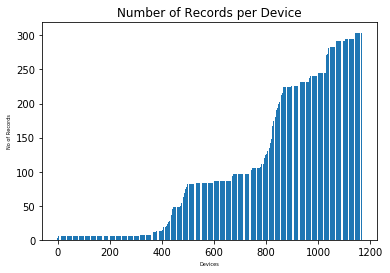

In [6]:
# ============ Records per Device ============ #
"""
# Shows the number of records per each device in a daily basis
"""
record_devices = df.groupby('device')['date'].count()

gplot(x=record_devices.index, y=record_devices,
      ylabel='No of Records', xlabel='Devices',
      tittle='Number of Records per Device',
      bar=True)

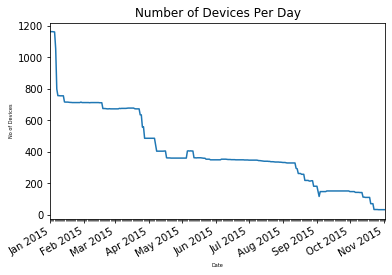

In [7]:
# ============ No of Devices each day ============ #

devices_per_date = df.groupby('date')[['device']].count()
# print(devices_per_date)

gplot(x=devices_per_date.index, y=devices_per_date,
      ylabel='No of Devices', xlabel='Date',
      tittle='Number of Devices Per Day')


In [8]:
# ============ Calculation of Failure rates and survival rates ============ #

failure_rate = (failed_devices / failure_records)
print(str(round(failure_rate * 100, 2)) + '%')

replace_rate = ((init_devices - end_devices) / init_devices)
print(str(round(replace_rate * 100, 2)) + '%')

survival_rate = 1 - replace_rate
print(str(round(survival_rate * 100, 2)) + '%')

0.09%
97.33%
2.67%


In [9]:
# ============ Similarity within Attribute columns ============ #
df_col = list(df)

for c in df_col:
    if 'attr' in c:
        for i in df_col:
            if i != c and df[c].equals(df[i]) is True:
                print('column %s and %s are the same' % (c, i))

column attribute7 and attribute8 are the same
column attribute8 and attribute7 are the same


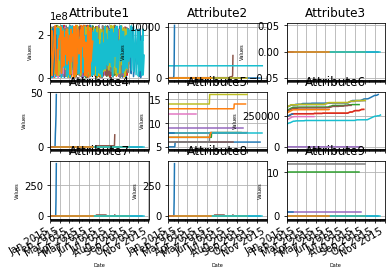

In [10]:
# ============ Atrributes Time Series ============ #

devices_sample = ['W1F0DXT8', 'S1F0S4MG', 'W1F0KRWP', 'W1F0W3GE', 'W1F1BAE6', 'S1F0LD15',
                  'W1F0X5TL', 'Z1F1R76A', 'S1F135F3', 'S1F12Y53', 'S1F0P3G2', 'Z1F0K451']

"""
Devices obtained using the pandas sample generator

devices_sample = df['device'].sample(n=10).reset_index(drop=True)
"""

devices_sample_df = df[df['device'] == devices_sample[0]]

for ds in devices_sample:
    if ds == devices_sample[0]:
        continue
    devices_sample_df = devices_sample_df.append(df[df['device'] == ds])


# print(devices_sample_df)

figure, xplot = plt.subplots(3, 3)

for col in range(9):

    xplot = plt.subplot(3, 3, col + 1)
    for ds in devices_sample:
        attribute_df = devices_sample_df[devices_sample_df['device'] == ds][['date', 'attribute' + str(col + 1)]]
        xplot.plot(attribute_df.date, attribute_df['attribute' + str(col + 1)])

        xplot.xaxis.set_major_locator(mdates.MonthLocator())
        xplot.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        xplot.xaxis.set_minor_locator(mdates.DayLocator())
        xplot.set_xlim(date_min, date_max)
        xplot.grid(True)
        figure.autofmt_xdate()
        plt.ylabel('Values', fontsize=5)
        plt.xlabel('Date', fontsize=5)
        plt.title('Attribute' + str(col + 1))

# plt.show()
# sleep(10)



In [15]:
# ============ Confusion Matrix / Model Evaluation ============ #

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    # This function prints and plots the confusion matrix.
    # Normalization can be applied by setting `normalize=True`.
    # Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)
    
    
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""

    baseline = {}

    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5

    results = {}

    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)

    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)

    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()}'
              f' Baseline: {round(baseline[metric], 2)}'
              f' Test: {round(results[metric], 2)}'
              f' Train: {round(train_results[metric], 2)}')

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize=(8, 6))
    plt.rcParams['font.size'] = 16

    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label='baseline')
    plt.plot(model_fpr, model_tpr, 'r', label='model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('ROC Curves');

In [45]:
# ============ Data Transformation / Feature Engineering ============ #

data_tfe = df.copy()
data_tfe.drop(columns=['attribute8'], axis=1, inplace=True)  # Drop attributes8 column as duplicate
data_tfe.rename(columns={'attribute9': 'attribute8'}, inplace=True)  # Rename Column to give consistency
data_tfe.drop(list(data_tfe[data_tfe['date'] < '2015-01-07'].index), inplace=True)  # Drop records for removed devices
data_tfe.drop(list(data_tfe[data_tfe['date'] > '2015-10-27'].index), inplace=True)  # Drop records for devices that weren't removed
data_tfe = data_tfe.fillna(0)
data_grp = data_tfe

for col in range(8):  # Enhance features of dataset with mean, std, var and median
    data_grp['attribute' + str(col + 1) + '_mean'] = data_grp['attribute' + str(col + 1)] - data_grp['attribute' + str(col + 1)].mean()
    data_grp['attribute' + str(col + 1) + '_std'] = data_grp['attribute' + str(col + 1)] - data_grp['attribute' + str(col + 1)].std()
    data_grp['attribute' + str(col + 1) + '_var'] = data_grp['attribute' + str(col + 1)] - data_grp['attribute' + str(col + 1)].var()
    data_grp['attribute' + str(col + 1) + '_median'] = data_grp['attribute' + str(col + 1)] - data_grp['attribute' + str(col + 1)].median()

    

data_grp = data_tfe.groupby(['device', 'date']).mean()  # Group by device and date

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Average number of nodes 232
Average maximum depth 18


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Recall Baseline: 1.0 Test: 0.0 Train: 0.99
Precision Baseline: 0.0 Test: 0.0 Train: 1.0
Roc Baseline: 0.5 Test: 0.71 Train: 1.0
Confusion matrix, without normalization
[[35214     6]
 [   32     0]]


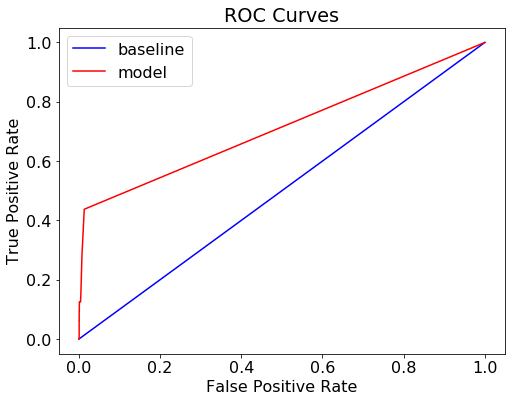

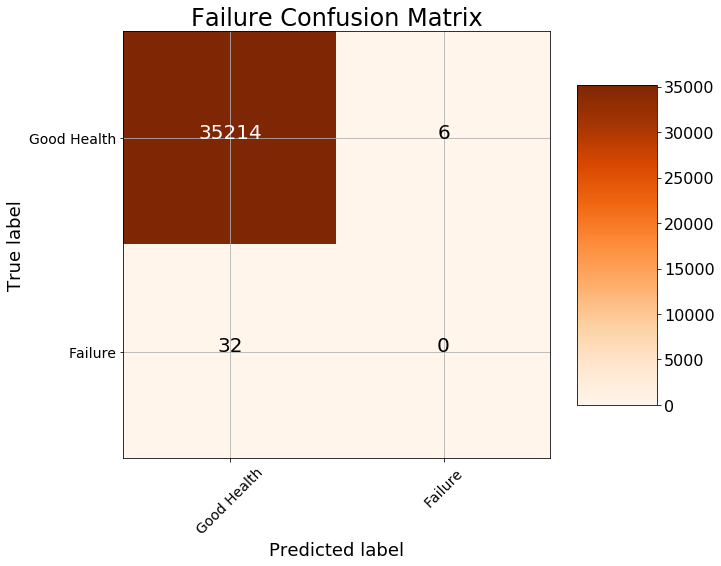

In [46]:
# ============ RandomForest Modelling ============ #
# Extract the labels

labels = np.array(data_grp.pop('failure'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(data_grp, labels,
                                                          stratify=labels,
                                                          test_size=0.3,
                                                          random_state=50)

train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100,
                               bootstrap=True,
                               max_features='sqrt',
                               n_jobs=-1,
                               verbose=1)
# Fit on training data
model.fit(train, train_labels)

n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)

print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Good Health', 'Failure'],
                      title='Failure Confusion Matrix')


